In [1]:
import os
import json
import yaml
import numpy as np
import pandas as pd

from tensorboard.backend.event_processing import event_accumulator

In [2]:
def parse_tensorboard(path, scalars):
    """returns a dictionary of pandas dataframes for each requested scalar"""
    ea = event_accumulator.EventAccumulator(
        path,
        size_guidance={event_accumulator.SCALARS: 0},
    )
    _absorb_print = ea.Reload()
    # make sure the scalars are in the event accumulator tags
    assert all(
        s in ea.Tags()["scalars"] for s in scalars
    ), "some scalars were not found in the event accumulator"
    return {k: pd.DataFrame(ea.Scalars(k)) for k in scalars}

In [4]:
model_path = f"../experiments/feedforwardmask_synthetic_continual_er_1111_1.0/feedforwardmask/version_0/"
num_tasks = 9

tasks = {}
steps = {}

flagged_likelihoods = {}
flagged_steps = {}

for seed in [1111]:
    for task in range(num_tasks):
        # Get TB
        lowest = np.inf
        starting_tb = None
        for file in os.listdir(f"{model_path.replace('125125125', str(seed))}/task_{task}/"):
            if "events" in file:
                try:
                    tb = parse_tensorboard(f"{model_path.replace('125125125', str(seed))}/task_{task}/{file}", ["likelihood"])['likelihood']
                except:
                    continue

        # Get the flagged likelihood
        try:
            log = open(f"{model_path.replace('125125125', str(seed))}/task_{task}/log.txt", 'r').readlines()[0]
            flag = float(log.split(" > ")[0].split(" ")[-1])
        except:
            flag = np.nan

        if task in tasks.keys():
            tasks[task].append(tb.value)
            steps[task].append(tb.step)
            flagged_likelihoods[task].append(flag)
            flagged_steps[task].append(tb.step[0])
        else:
            tasks[task] = [tb.value]
            steps[task] = [tb.step]
            flagged_likelihoods[task] = [flag]
            flagged_steps[task] = [tb.step[0]]

In [5]:
flagged_likelihoods

{0: [nan],
 1: [nan],
 2: [nan],
 3: [nan],
 4: [nan],
 5: [nan],
 6: [nan],
 7: [nan],
 8: [nan]}

In [6]:
# Get mean over tasks
mean_tasks = {}
std_tasks = {}
for task in tasks.keys():
    mean_tasks[task] = np.mean(tasks[task], axis=0)
    std_tasks[task] = np.std(tasks[task], axis=0)

In [7]:
# Get mean over tasks
mean_flags = {}
std_flags = {}
for task in tasks.keys():
    mean_flags[task] = np.nanmean(flagged_likelihoods[task], axis=0)
    std_flags[task] = np.nanstd(flagged_likelihoods[task], axis=0)

/tmp/ipykernel_7153/123526849.py:5: RuntimeWarning: Mean of empty slice
  mean_flags[task] = np.nanmean(flagged_likelihoods[task], axis=0)
/home/rxm7244/miniconda3/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


/home/rxm7244/miniconda3/lib/python3.10/site-packages/matplotlib/axes/_axes.py:1185: RuntimeWarning: All-NaN axis encountered
  miny = np.nanmin(masked_verts[..., 1])
/home/rxm7244/miniconda3/lib/python3.10/site-packages/matplotlib/axes/_axes.py:1186: RuntimeWarning: All-NaN axis encountered
  maxy = np.nanmax(masked_verts[..., 1])


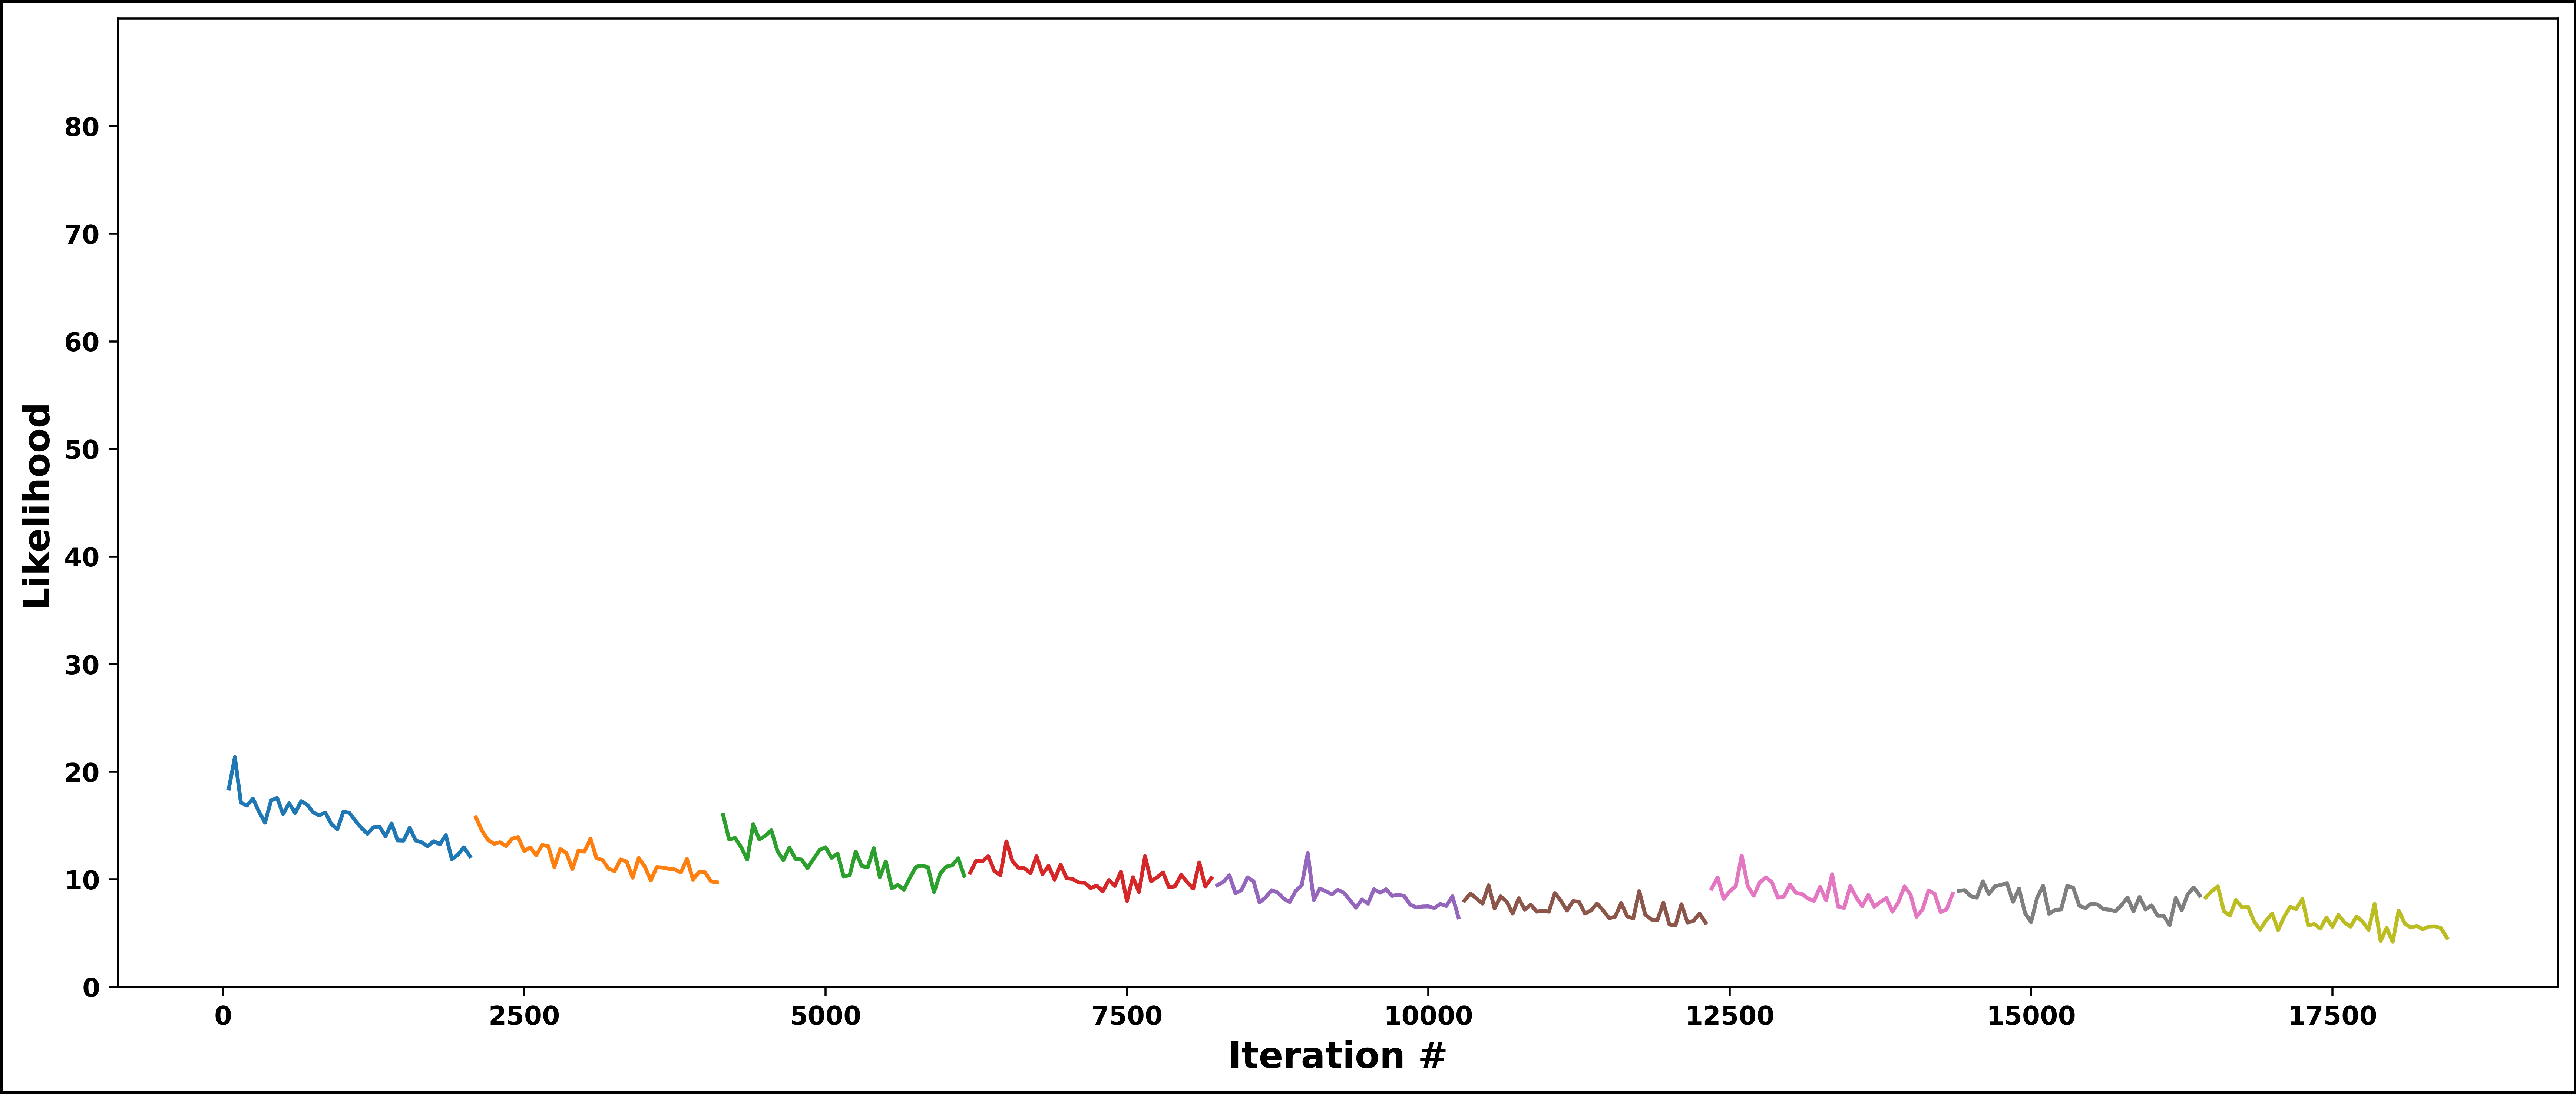

In [8]:
import matplotlib.pyplot as plt
import numpy as np

params = {'font.weight': 'bold'} 
plt.rcParams.update(params)

lines = [f'Task {i+1}' for i in range(num_tasks)]  # Labels for each line

# Create a figure for the line plot
fig, ax = plt.subplots(figsize=(14, 6), dpi=500)

# Plot each line with its corresponding std
for i in range(num_tasks):
    line_plot, = ax.plot(steps[i][0], mean_tasks[i], label=lines[i])  # Line plot
    ax.fill_between(steps[i][0],  mean_tasks[i] - std_tasks[i],  mean_tasks[i] + std_tasks[i], alpha=0.3, color=line_plot.get_color())  # Error band (std)
#     ax.fill_between(steps[i][0],  mean_tasks[i] - (3 * std_tasks[i]),  mean_tasks[i] + (3 * std_tasks[i]), alpha=0.15, color=line_plot.get_color())  # Error band (std)

    if i > 0:
        # Add scatter points with error bars at the mean with std
        ax.errorbar(flagged_steps[i][0], mean_flags[i], yerr=std_flags[i], fmt='x', color=line_plot.get_color(),
                label=f'{lines[i]} Mean', capsize=5, markersize=8)  # Scatter point with matching color

        # # Add scatter points with error bars at the mean with std
        # ax.errorbar(flagged_steps[i][0], np.nanmin(flagged_likelihoods[i]), fmt='o', color=line_plot.get_color(),
        #         label=f'{lines[i]} Mean', capsize=5, markersize=8)  # Scatter point with matching color


# Set labels and title
ax.set_xlabel('Iteration #', fontsize=14, fontweight='bold')
ax.set_ylabel('Likelihood', fontsize=14, fontweight='bold')
ax.set_yticks(range(0, 90, 10))

if num_tasks == 12:
        ax.set_ylim([0, 30])
else:
        ax.set_ylim([0, 90])
# ax.set_title('Line Plot with Standard Deviation', fontsize=16)

# Create a shared legend below the plot
# handles, labels = ax.get_legend_handles_labels()  # Get handles and labels from the plot
# legend = fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=17, fontsize=12, frameon=True)

# Customize legend to block out lines behind it
# legend.get_frame().set_facecolor('white')  # Set solid white background
# legend.get_frame().set_edgecolor('black')  # Add black border around the legend
# legend.get_frame().set_alpha(1)  # Ensure no transparency

# ax.grid(True, axis='y')

# Adjust layout to prevent overlap and make room for the bounding boxes, titles, and shared legend
plt.tight_layout()  # Increased bottom space for the legend

fig.patch.set_linewidth(2)
fig.patch.set_edgecolor('black')

# Show the plot
if num_tasks == 12:
        plt.savefig("boundaryDetectionG6.svg", bbox_inches='tight')
else:
        plt.savefig("boundaryDetectionMP.svg", bbox_inches='tight')
plt.show()